In [1]:
from IPython.utils import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io.arff import loadarff 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import(
    train_test_split, 
    KFold,
    GridSearchCV,
)

import tensorflow as tf
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax
from keras.wrappers.scikit_learn import KerasClassifier

#utils
from utils.mlp import MLP # MLP implementado no Keras para utilização da GPU
from utils.metric import Metrics, Results # Funções auxiliares para computar, plotar e salvar métricas

import warnings
warnings.filterwarnings('ignore')

Limitando o uso de VRAM

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

2022-09-01 15:56:00.180518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 15:56:00.208763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 15:56:00.208927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Definição de funções auxiliares

### Para K-Fold CV e GridSearch

In [3]:
def kfold_grid(kf, grid, X, y):
      accuracies_list = list()
      f1_list = list()
      conf_matrix_list = list()
      roc_list = list()
      grid_results = list()

      for fold, (train, test) in enumerate(kf.split(X, y)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            if type(grid.estimator).__name__ == 'KerasClassifier':
                  y_train = to_categorical(y_train, num_classes=10)
            else:
                  y_train = y_train.values.ravel()

            with io.capture_output() as captured:
                  grid.fit(X_train, y_train)
                  y_pred = grid.predict(X_test)
                  y_score = grid.predict_proba(X_test)

            accuracy, f1, conf_matrix, roc = Metrics(y_test,y_pred, y_score).compute()
            
            print(f"Fold {fold}\t Accuracy: {accuracy:.3f}")
            print(F"Model best params: {grid.best_params_}")

            accuracies_list.append(accuracy)
            f1_list.append(f1)
            conf_matrix_list.append(conf_matrix)
            roc_list.append(roc)
            grid_results.append(grid.cv_results_)

      return accuracies_list, f1_list, conf_matrix_list, roc_list, grid_results


def grid_Search(kf, model, params, X, y, n_jobs=None):
      grid = GridSearchCV(estimator=model, param_grid=params,
                          scoring='accuracy', n_jobs=n_jobs, 
                          cv=5, refit=True)

      return kfold_grid(kf, grid, X, y)

### Visualização de instâncias do DS

In [4]:
# plot multiple numbers

def plot_images(images):
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap='gray_r')
        ax.axis('off')
    
    fig.suptitle('Representação de números aleatórios do dataset')

# DataSet

### Carregando o DataSet

In [5]:
# loading data
raw_data = loadarff('mnist_784.arff')
mnist = pd.DataFrame(raw_data[0])

Devido à limitações de hardware, tomaremos uma amostra estratificada de tamanho n = 2000

In [6]:
df = mnist.groupby('class', group_keys=False).apply(
    lambda x: x.sample(500, random_state=1, ignore_index=True)
    ).sample(frac=1, ignore_index=True, random_state=1)

df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'9'
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'7'
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'6'
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'5'
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'1'
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'7'


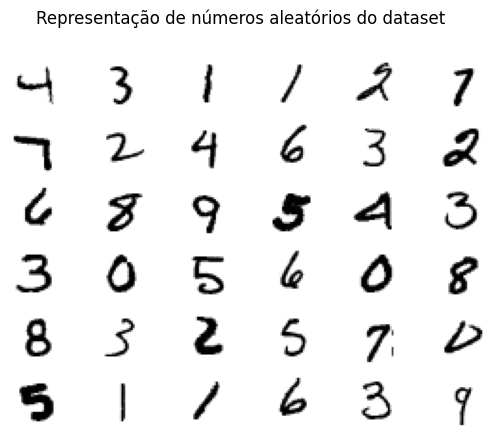

In [7]:
# Visualizando algumas instância do dataset
nums = df['class'].unique()

imgs = list()
for i in np.random.randint(100, size=36):
    rnd_choice = np.random.choice(nums)
    img = pd.array(df[df['class'] == rnd_choice].iloc[i][:-1],
                 dtype=int).reshape((28,28))
    imgs.append(img)

plot_images(imgs)


#### Separando os dados de treino e teste

In [8]:
# treino e teste
X = df.iloc[:, 0:-1]
y = df.iloc[:, [-1]].astype('int') # target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

kf = KFold(n_splits=10, shuffle=True)

# Experimentos

### Decision Tree

Fold 0	 Accuracy: 0.738
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 1	 Accuracy: 0.753
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 10}
Fold 2	 Accuracy: 0.764
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 10}
Fold 3	 Accuracy: 0.738
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 5}
Fold 4	 Accuracy: 0.798
Model best params: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 100, 'min_samples_split': 5}
Fold 5	 Accuracy: 0.749
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 10}
Fold 6	 Accuracy: 0.711
Model best params: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 100, 'min_samples_split': 5}
Fold 7	 Accuracy: 0.740
Model best params: {'criterion': 'entropy', 'max_depth': 5

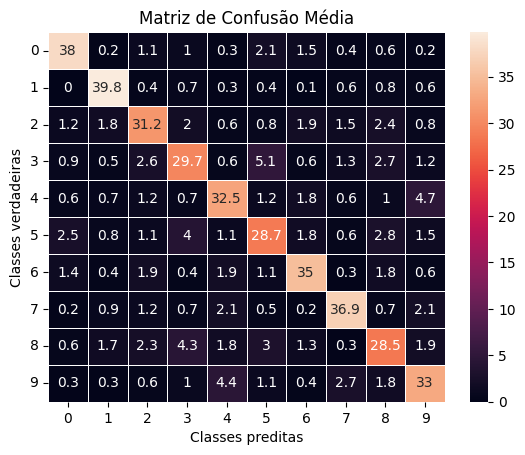

In [10]:
DT = DecisionTreeClassifier()
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[5, 50, 100],
    'min_samples_split': [5, 10, 30],
    'max_features':[10, 30, 100, 'sqrt'],
}
dt_acc, dt_f1, dt_cm, dt_roc, dt_grid_results = grid_Search(kf, DT, dt_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
dt_results = Results(type(DT).__name__, dt_acc, dt_f1,
                           dt_cm, dt_roc, dt_grid_results)
dt_results.save()
dt_results.plot()


### Naive Bayes

#### Gaussian NB

Fold 0	 Accuracy: 0.842
Model best params: {'var_smoothing': 0.1}
Fold 1	 Accuracy: 0.816
Model best params: {'var_smoothing': 0.1}
Fold 2	 Accuracy: 0.798
Model best params: {'var_smoothing': 0.1}
Fold 3	 Accuracy: 0.804
Model best params: {'var_smoothing': 0.1}
Fold 4	 Accuracy: 0.780
Model best params: {'var_smoothing': 0.1}
Fold 5	 Accuracy: 0.789
Model best params: {'var_smoothing': 0.1}
Fold 6	 Accuracy: 0.798
Model best params: {'var_smoothing': 0.1}
Fold 7	 Accuracy: 0.831
Model best params: {'var_smoothing': 0.1}
Fold 8	 Accuracy: 0.813
Model best params: {'var_smoothing': 0.1}
Fold 9	 Accuracy: 0.840
Model best params: {'var_smoothing': 0.1}

-----------------------------------------------------

Resumo das métricas do modelo GaussianNB

Accurácia média (desvio): 0.811 (0.020)
F1-Score média (desvio): 0.811 (0.020)


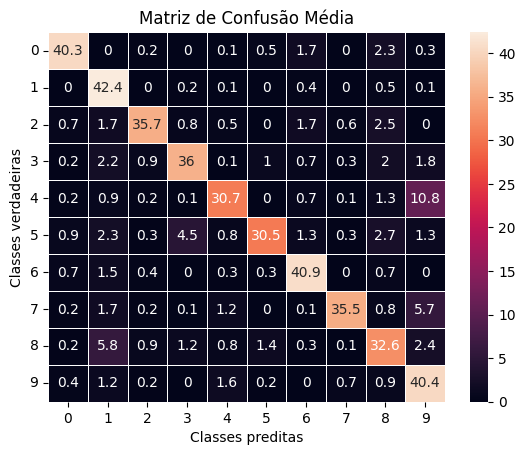

In [11]:
gnb = GaussianNB()
gnb_params = {
    'var_smoothing': np.logspace(0,-9, num=10)
}

gnb_acc, gnb_f1, gnb_cm, gnb_roc, gnb_grid_results = grid_Search(kf, gnb, gnb_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
gnb_results = Results(type(gnb).__name__, gnb_acc, gnb_f1,
                           gnb_cm, gnb_roc, gnb_grid_results)
gnb_results.save()
gnb_results.plot()


#### Multinomial NB

Fold 0	 Accuracy: 0.836
Model best params: {'alpha': 0.001}
Fold 1	 Accuracy: 0.822
Model best params: {'alpha': 1.0}
Fold 2	 Accuracy: 0.813
Model best params: {'alpha': 0.1}
Fold 3	 Accuracy: 0.849
Model best params: {'alpha': 1.0}
Fold 4	 Accuracy: 0.849
Model best params: {'alpha': 0.001}
Fold 5	 Accuracy: 0.818
Model best params: {'alpha': 1.0}
Fold 6	 Accuracy: 0.822
Model best params: {'alpha': 1.0}
Fold 7	 Accuracy: 0.842
Model best params: {'alpha': 1.0}
Fold 8	 Accuracy: 0.869
Model best params: {'alpha': 1.0}
Fold 9	 Accuracy: 0.829
Model best params: {'alpha': 0.01}

-----------------------------------------------------

Resumo das métricas do modelo MultinomialNB

Accurácia média (desvio): 0.835 (0.016)
F1-Score média (desvio): 0.836 (0.016)


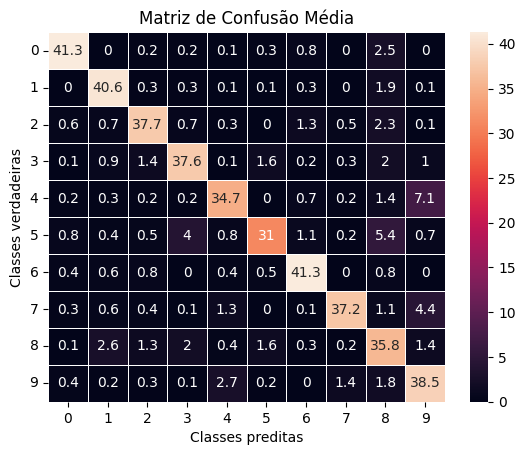

In [12]:
mnnb = MultinomialNB()
mnnb_params = {
    'alpha': np.logspace(0,-9, num=10)
}

mnnb_acc, mnnb_f1, mnnb_cm, mnnb_roc, mnnb_grid_results = grid_Search(kf, mnnb, mnnb_params,
                                                   X_train, y_train, n_jobs=-1)


print("\n-----------------------------------------------------\n")
mnnb_results = Results(type(mnnb).__name__, mnnb_acc, mnnb_f1, 
                           mnnb_cm, mnnb_roc, mnnb_grid_results)
mnnb_results.save()
mnnb_results.plot()

### KNN

Fold 0	 Accuracy: 0.931
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 1	 Accuracy: 0.927
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 2	 Accuracy: 0.893
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}
Fold 3	 Accuracy: 0.927
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}
Fold 4	 Accuracy: 0.949
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}
Fold 5	 Accuracy: 0.933
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 6	 Accuracy: 0.942
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}
Fold 7	 Accuracy: 0.920
Model best params: {'metric': 'euclidean', 'n_neighbors': 3}
Fold 8	 Accuracy: 0.920
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}
Fold 9	 Accuracy: 0.911
Model best params: {'metric': 'euclidean', 'n_neighbors': 5}

-----------------------------------------------------

Resumo das métricas do modelo KNeighborsClassifier

Accurácia média (desvio): 0.925 (0.015)
F1

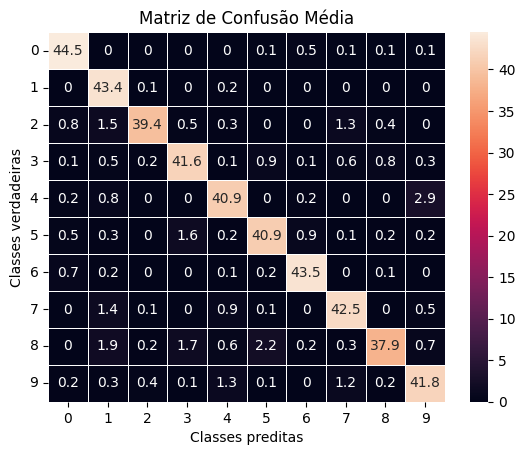

In [13]:
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7],
             'metric': ['euclidean', 'manhattan']}

knn_acc, knn_f1, knn_cm, knn_roc, knn_grid_results = grid_Search(kf, knn, knn_params, X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
knn_results = Results(type(knn).__name__, knn_acc, knn_f1, 
                           knn_cm, knn_roc, knn_grid_results)
knn_results.save()
knn_results.plot()

### SVC

In [14]:
svc = SVC(probability=True)

svc_params = [
    {'C': np.logspace(4,-1, num=6),
     'kernel':['linear']},
    
    {'C': np.logspace(4,-1, num=6),
     'kernel': ['poly'],
     'degree': [2, 3]},
]

svc_acc, svc_f1, svc_cm, svc_roc, svc_grid_results = grid_Search(kf, svc, svc_params,
                                               X_train, y_train, n_jobs=-1)

print("\n-----------------------------------------------------\n")
svc_results = Results(type(svc).__name__, svc_acc, svc_f1, 
                           svc_cm, svc_roc, svc_grid_results)
svc_results.save()
svc_results.plot()


Fold 0	 Accuracy: 0.927
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}
Fold 1	 Accuracy: 0.962
Model best params: {'C': 10.0, 'degree': 2, 'kernel': 'poly'}


### MLP

In [ ]:
mlp = KerasClassifier(build_fn=MLP, n_classes=10, input_shape=(28*28,), verbose=0)

mlp_params = {
    'epochs': [20, 30, 50],
    'batch_size':[128, 256],
    'n_neurons':[[500]*2, [1000]*2, [500]*3, [1000]*3],
    'optimizer': [Adam, Adamax, SGD],
    'lr': [0.001, 0.002, 0.003],
}


mlp_acc, mlp_f1, mlp_cm, mlp_roc, mlp_grid_results = grid_Search(kf, mlp, mlp_params, X_train, y_train)

print("\n-----------------------------------------------------\n")
mlp_results = Results('MLP', mlp_acc, mlp_f1, 
                           mlp_cm, mlp_roc, mlp_grid_results)
mlp_results.save()
mlp_results.plot()
